In [ ]:
#  TensorFlow & Keras Core
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, save_model  # ✅ Save & Load Models



# Pretrained Models (VGG16, ResNet, etc.)
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input  # ✅ Preprocess images


#  Model Layers
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
)


#  File Handling
import os
from PIL import Image


#  Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#  Model Evaluation (Accuracy, Confusion Matrix, etc.)
from sklearn.metrics import classification_report, confusion_matrix


#  Hyperparameter Tuning
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


In [6]:
# Define paths
train_dir = r'E:\6th_project\Skin_Disease_Classification\dataset\Split_smol\train'
val_dir = r'E:\6th_project\Skin_Disease_Classification\dataset\Split_smol\val'


In [7]:
def predict(filename, model):
    img = load_img(filename, target_size=(240, 240))  # Ensure correct size
    img = img_to_array(img)
    
    # Ensure the shape is (240, 240, 3)
    print("Original Image Shape:", img.shape)  # Debugging step
    
    img = img.reshape(1, 240, 240, 3)  # Ensure correct batch shape
    img = img.astype('float32') / 255.0  # Normalize

    result = model.predict(img)

    dict_result = {}
    for i in range(len(classes)):  # Ensure loop doesn't exceed array length
        dict_result[result[0][i]] = classes[i]

    res = sorted(result[0], reverse=True)  # Sort predictions in descending order
    prob_result = [(p * 100).round(2) for p in res[:4]]
    class_result = [dict_result[p] for p in res[:4]]

    return class_result, prob_result


In [ ]:

def preprocess_image(image_path, target_size=(240, 240)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)  # Resize to match training size
    img = img_to_array(img)
    img = img / 255.0  # Normalize if required by the model
    img = img.flatten().reshape(1, -1)  # Ensure correct shape
    return img


In [16]:
# Image dimensions
img_height, img_width = 240, 240
batch_size = 64

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using val_datagen
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10106 images belonging to 11 classes.
Found 1259 images belonging to 11 classes.


In [17]:
# Define the CNN model
from tensorflow.keras import models, layers

img_height, img_width = 240, 240  # Define image dimensions

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(11, activation='softmax')  # Output layer for 11 classes
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 238, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 119, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    11,076,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,322,571 (43.19 MB)

 Trainable params: 11,322,571 (43.19 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Or any other metric you want to monitor
                               patience=5,           # Number of epochs to wait for improvement
                               restore_best_weights=True)  # Restore the best weights after stopping

# Now you can proceed with training your model
history = model.fit(
    train_generator,
    steps_per_epoch=int(np.ceil(train_generator.samples / batch_size)),  # Convert to int
    epochs=50,  # Ensure it's an integer
    validation_data=val_generator,
    validation_steps=int(np.ceil(val_generator.samples / batch_size)),  # Convert to int
    callbacks=[early_stopping]  # Pass the defined callback
)


C:\Users\jaary\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.2079 - loss: 2.1475 - val_accuracy: 0.3654 - val_loss: 1.8189
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.3420 - loss: 1.7243 - val_accuracy: 0.3773 - val_loss: 1.6814
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.4078 - loss: 1.5664 - val_accuracy: 0.4035 - val_loss: 1.5457
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.4281 - loss: 1.4800 - val_accuracy: 0.3535 - val_loss: 1.7590
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.4391 - loss: 1.4612 - val_accuracy: 0.4186 - val_loss: 1.6913
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.4684 - loss: 1.3701 - val_accuracy: 0.4639 - val_loss: 1.5021
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.4790 - loss: 1.3440 - val_accuracy: 0.4559 - val_loss: 1.4851
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.4808 - loss: 1.3213 - val_accu

In [19]:
# Save the model
model.save('skin_disease_classification_model.h5')


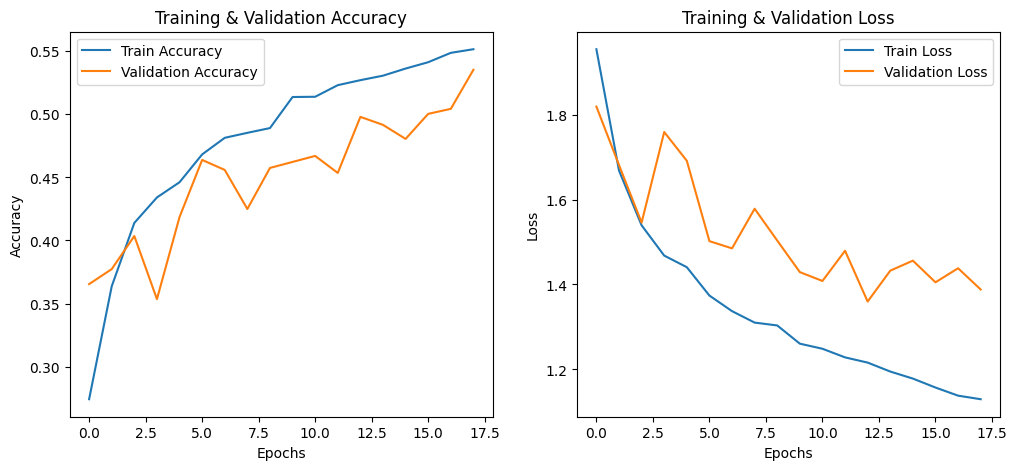

Potential Overfitting: Validation loss is higher than training loss.


In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

# Diagnose Issues (Overfitting/Underfitting)
if history.history['val_loss'][-1] > history.history['loss'][-1]:
    print("Potential Overfitting: Validation loss is higher than training loss.")
elif history.history['val_accuracy'][-1] < history.history['accuracy'][-1]:
    print("Potential Overfitting: Validation accuracy is lower than training accuracy.")
else:
    print("No significant overfitting detected.")


In [22]:
def predict(filename, model):
    # Load and preprocess the image
    img = load_img(filename, target_size=(240, 240))
    img = img_to_array(img)
    img = img.reshape(1, 240, 240, 3)
    img = img.astype('float32') / 255.0

    # Predict probabilities for each class
    result = model.predict(img)[0]

    # Identify top 4 predictions
    top_indices = np.argsort(result)[::-1][:4]
    class_result = [classes[i] for i in top_indices]
    prob_result = [(result[i] * 100).round(2) for i in top_indices]

    # Set confidence threshold (e.g., 40%)
    threshold = 40.0

    # Check if the highest probability is below the threshold
    if prob_result[0] < threshold:
        class_result[0] = "unknown"

    return class_result, prob_result


Found 1260 images belonging to 11 classes.


C:\Users\jaary\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step


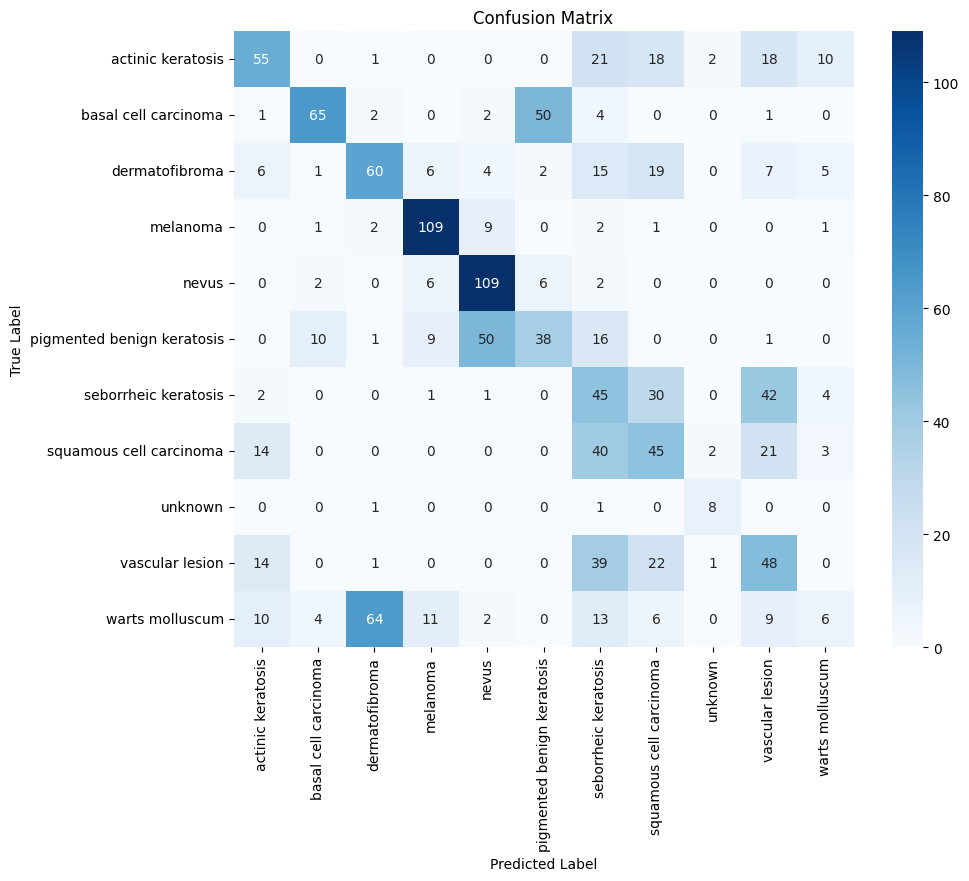


Classification Report:

                            precision    recall  f1-score   support

         actinic keratosis       0.54      0.44      0.48       125
      basal cell carcinoma       0.78      0.52      0.62       125
            dermatofibroma       0.45      0.48      0.47       125
                  melanoma       0.77      0.87      0.82       125
                     nevus       0.62      0.87      0.72       125
pigmented benign keratosis       0.40      0.30      0.34       125
      seborrheic keratosis       0.23      0.36      0.28       125
   squamous cell carcinoma       0.32      0.36      0.34       125
                   unknown       0.62      0.80      0.70        10
           vascular lesion       0.33      0.38      0.35       125
           warts molluscum       0.21      0.05      0.08       125

                  accuracy                           0.47      1260
                 macro avg       0.48      0.49      0.47      1260
              weighte

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Define paths
TEST_DIR = "E:/6th_project/Skin_Disease_Classification/dataset/Split_smol/test"
MODEL_PATH = "E:/6th_project/Skin_Disease_Classification/skin_disease_classification_model.h5"

# Load trained model
model = load_model(MODEL_PATH)

# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep file order for correct labels
)

# Get true labels
y_true = test_generator.classes

# Predict on test data
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Class labels (Fixed missing comma issue)
class_names = [
    'actinic keratosis',
    'basal cell carcinoma',
    'dermatofibroma',
    'melanoma',
    'nevus',
    'pigmented benign keratosis',
    'seborrheic keratosis',
    'squamous cell carcinoma',
    'unknown',  # Fixed missing comma
    'vascular lesion',
    'warts molluscum'
]

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
